# COMP90086 Final Project

Team Number: 55

Members: Einon McGrory-Perich (992697),     Xing Yang Goh (1001969)

In [116]:
import os 
import math
import matplotlib.pyplot as plt 
import numpy as np
import cv2
from scipy.signal import fftconvolve

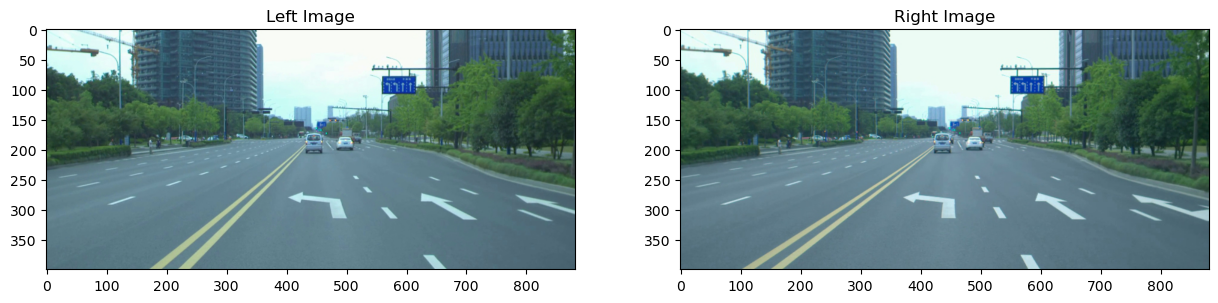

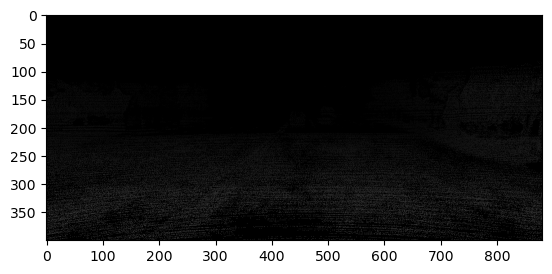

In [148]:
# Import images 
directory = './Dataset/'
allfiles = os.listdir(directory)

filenames = []

for filename in allfiles:
    if 'left' in filename:
        filenames.append(filename[0:filename.index('left')])

# List of files obtained

# Perform on first image for now 

file = filenames[0]

left_image_name = directory + file + 'left.jpg'
right_image_name = directory+ file + 'right.jpg'
disp_image_name = directory+ file + 'disparity.png'

# Read images and convert to RGB 
img_l = cv2.imread(left_image_name)
img_r = cv2.imread(right_image_name)

# Grey images
img_l_grey = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
img_r_grey = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)


img_l = img_l[...,::-1]
img_r = img_r[...,::-1]

# Plot images 
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img_l)
plt.title('Left Image')

plt.subplot(1,2,2)
plt.imshow(img_r)
plt.title('Right Image')

plt.show()

img_d = cv2.imread(disp_image_name)
plt.imshow(img_d)

9883
0.007881945383472548


Text(0.5, 1.0, 'SSD')

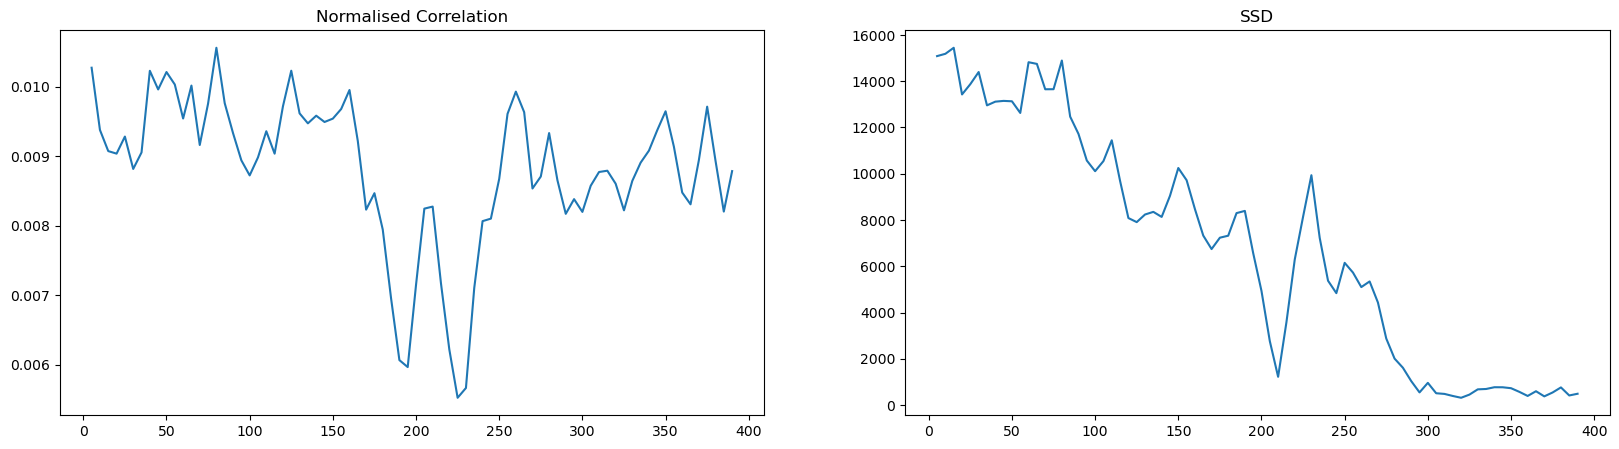

In [158]:
# As driving assume that any two points have the same y value (camera is flat)

# For every y value in both left and right
#     For every x value in left, find the corresponding SSD error (10x10 box) for each x point in right image
#     Select mininum error - treat this as corresponding point

# For every corresponding set of points, find the disparity, x-x'
#     Find depth z by estimating f and baseline distance


# Not certain if this function actually does what I imagine it does

# centre positions given by [row,column]

# sum of squared differenced method to find disparity between images   
def sum_squared_differences(img_l, img_r, centre_l, centre_r, boundary_size):
    # Column
    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size

    min_r_x = centre_r[1] - boundary_size
    max_r_x = centre_r[1] + boundary_size
    # Row
    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size
    
    min_r_y = centre_r[0] - boundary_size
    max_r_y = centre_r[0] + boundary_size
    
    patch_l = img_l[min_l_y:max_l_y,min_l_x:max_l_x]
    patch_r = img_r[min_r_y:max_r_y,min_r_x:max_r_x]

    # Error of RGB values
    # error = np.sum((img_l[min_l_y:max_l_y,min_l_x:max_l_x,:] - img_r[min_r_y:max_r_y,min_r_x:max_r_x,:])**2)

    # Error of Grey values
    error = np.sum((patch_l - patch_r)**2)

    return error

    
def norm_correlation(img_l, img_r, centre_l, centre_r, boundary_size):

    # Column
    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size
    
    min_r_x = centre_r[1] - boundary_size
    max_r_x = centre_r[1] + boundary_size

    # Row
    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size

    min_r_y = centre_r[0] - boundary_size
    max_r_y = centre_r[0] + boundary_size
    
    patch_l = img_l[min_l_y:max_l_y,min_l_x:max_l_x]
    patch_r = img_r[min_r_y:max_r_y,min_r_x:max_r_x]

    norm_corr = np.sum(np.dot(patch_l,patch_r))/(np.linalg.norm(patch_l, 'fro')*np.linalg.norm(patch_r, 'fro'))
    return norm_corr

boundary_size = 5
row = 350
left_image = [row,400]
SSD = []
corr = []
pixel_loc = []
for i in range(boundary_size, len(img_l)-boundary_size, boundary_size):
    pixel_loc.append(i)
    corr.append(norm_correlation(img_l_grey, img_r_grey, left_image, [row,i], boundary_size))
    SSD.append(sum_squared_differences(img_l_grey, img_r_grey, left_image, [row,i], boundary_size))


plt.subplots(1,2, figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(pixel_loc, corr)
plt.title('Normalised Correlation')

plt.subplot(1,2,2)
plt.plot(pixel_loc, SSD)
plt.title('SSD')


# 
# calc_disp = np.zeros((400,881))
# for row_index in range(boundary_size,len(img_l)-boundary_size,5):
#     row = img_l[row_index]
#     # Should be the full bounds, but takes a very long time, consider using tensor operations on rows
#     for col_index_left in range(boundary_size,len(row)-boundary_size,5):
#         left_centre = [row_index, col_index_left]
#         min_col_index = 20
#         min_error = sum_squared_differences(img_l, img_r, left_centre, [row_index, min_col_index], 3)
#         for col_index_right in range(boundary_size,len(row)-boundary_size):
#             right_pixel = row[col_index_right]
#             right_centre = [row_index, col_index_right]
#             ssd_error = sum_squared_differences(img_l, img_r, left_centre, right_centre,3)
#             if min_error > ssd_error:
#                 min_error = ssd_error
#                 min_col_index = col_index_right
#         calc_disp[row_index][col_index_left] = min_col_index - col_index_left